**Packages installation**

In [3]:
!pip install numpy
!pip install pandas
!pip install forex-python
!pip install scipy
!pip install ydata-profiling
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.8 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.8 kB ? eta -:--:--
   --- ----------------------------------- 30.7/301.8 kB 325.1 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/301.8 kB 363.1 kB/s eta 0:00:01
   --------------- ---------------------- 122.9/301.8 kB 599.1 kB/s eta 0:00:01
   ------------------------- ------------ 204.8/301.8 kB 827.9 kB/s eta 0:00:01
   ---------------------------------------  297.0/301.8 kB 1.0 MB/s eta 0:00:01
   -------------------------------------- 301.8/301.8 kB 981.7 kB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1


**Imports**

In [4]:
import numpy as np 
import pandas as pd 
import re
import functools
import json
from forex_python.converter import CurrencyRates
from scipy import stats
from ydata_profiling import ProfileReport

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from forex_python.converter import CurrencyRates
import datetime as dt


from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

Merging all the CSV's into one dataset, and shuffling it with a specified seed for later reproductibility.

In [5]:
SEED = 42
np.random.seed(SEED)

In [6]:
dataset = pd.concat([pd.read_csv('Volkswagen_Golf.csv', na_values='Unknown'), pd.read_csv('BMW_Seria 3.csv', na_values='Unknown'), pd.read_csv('Opel_Corsa.csv', na_values='Unknown')])
dataset = dataset.sample(frac=1, random_state=SEED)
dataset.head()

,brand,model,generation,eng_cap,prod_year,power,fuel_type,car_body,mileage,color,condition,transmission,origin,price,source
1550,Volkswagen,Golf,VII (2012-2020),1 984 cm3,2017,310 KM,Benzyna,Kompakt,77 000 km,Biały,Używane,Automatyczna,NaN,114 000PLN,OTOMOTO
1221,Volkswagen,Golf,VIII (2020-),1 968 cm3,2022,150 KM,Diesel,Kompakt,32 000 km,Szary,Używane,Automatyczna,Polska,95 000PLN,OTOMOTO
1941,Volkswagen,Golf,VIII (2020-),1 968 cm3,2020,150 KM,Diesel,Kompakt,76 020 km,Czarny,Używane,Automatyczna,Francja,86 900PLN,OTOMOTO
573,BMW,Seria 3,E90/E91/E92/E93 (2005-2012),2 996 cm3,2005,258 KM,Benzyna,Sedan,288 858 km,Szary,Używane,Manualna,NaN,32 500PLN,OTOMOTO
173,Opel,Corsa,D (2006-2014),1 229 cm3,2009,80 KM,Benzyna,Kompakt,152 000 km,Czarny,Używane,Manualna,NaN,18 500PLN,OTOMOTO


Checking how the data looks:

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6867 entries, 1550 to 860
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         6867 non-null   object
 1   model         6867 non-null   object
 2   generation    6805 non-null   object
 3   eng_cap       6782 non-null   object
 4   prod_year     6867 non-null   int64 
 5   power         6861 non-null   object
 6   fuel_type     6867 non-null   object
 7   car_body      6867 non-null   object
 8   mileage       6867 non-null   object
 9   color         6867 non-null   object
 10  condition     6867 non-null   object
 11  transmission  6865 non-null   object
 12  origin        4154 non-null   object
 13  price         6867 non-null   object
 14  source        6867 non-null   object
dtypes: int64(1), object(14)
memory usage: 858.4+ KB


As we can see, there are columns, e.g. mileage or price, which definitely should be an integer value, and instead, every column except prod_year is the type of an object. In order to execute exploratory data analysis, we have to prepare the data.

Let's preprocess the data in the following way:

brand - object

model - object

generation - object

eng_cap - int [cm^3]

prod_year - int

power - int [KM]

fuel_type - object

car_body - object

mileage - int [km]

color - object

condition - object

transmission - object

origin - object

price - int [zł]

source - object (we can drop it right away, because in all samples it has one value: **OTOMOTO**)



In [8]:
dataset['eng_cap'] = dataset['eng_cap'].apply(lambda x: float(x.replace('cm3', '').replace(' ', '')) if not pd.isnull(x) else x)
dataset['power'] = dataset['power'].apply(lambda x: float(x.replace('KM', '').replace(' ', '')) if not pd.isnull(x) else x)
dataset['mileage'] = dataset['mileage'].apply(lambda x: int(x.replace('km', '').replace(' ', '')) if not pd.isnull(x) else x)

With the price, situation is more complicated, because it can be given in different currencies. We have to convert them all to PLN

In [9]:
# caching, so that getting online info about certain currency happens only once for the same input 
@functools.cache
def get_currency(base_cur: str, dest_cur: str, date_obj: dt.datetime) -> float:
    c = CurrencyRates()
    rate = c.get_rate(base_cur=base_cur, dest_cur='PLN', date_obj=date_obj)
    if not isinstance(rate, float):
        raise ValueError(f'One of the following function arguments was incorrect: {base_cur, dest_cur, date_obj}')
    return rate

def currency_to_PLN(value: str, rates: dict[str, float]) -> float:
    pattern = re.compile(r'([\d\s,]+)([^\d\s]+)')
    match = re.search(pattern, value)
    if match is None:
        raise ValueError(f'Unexpected price format: {value}')
    float_val = float(match.group(1).replace(' ', '').replace(',', '.'))
    base_curr = match.group(2)
    rate = rates.get(base_curr, None)
    if not rate:
        date = dt.datetime(2024, 5, 2, 16, 0) # set datetime for reproductability
        rate = get_currency(base_curr, 'PLN', date)
        rates[base_curr] = rate
    else:
        rate = rates[base_curr]
    return round(float_val * rate, 2)

with open('currency_rates_to_PLN.json', 'r') as file:
    try:
        rates_to_PLN = json.load(file)
    except json.decoder.JSONDecodeError:
        rates_to_PLN = {}
    
dataset['price'] = dataset['price'].apply(lambda x: float(currency_to_PLN(x, rates_to_PLN)) if not pd.isnull(x) else x)

with open('currency_rates_to_PLN.json', 'w') as file:
    json.dump(rates_to_PLN, file)

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6867 entries, 1550 to 860
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         6867 non-null   object 
 1   model         6867 non-null   object 
 2   generation    6805 non-null   object 
 3   eng_cap       6782 non-null   float64
 4   prod_year     6867 non-null   int64  
 5   power         6861 non-null   float64
 6   fuel_type     6867 non-null   object 
 7   car_body      6867 non-null   object 
 8   mileage       6867 non-null   int64  
 9   color         6867 non-null   object 
 10  condition     6867 non-null   object 
 11  transmission  6865 non-null   object 
 12  origin        4154 non-null   object 
 13  price         6867 non-null   float64
 14  source        6867 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 858.4+ KB


In [11]:
dataset.head()

,brand,model,generation,eng_cap,prod_year,power,fuel_type,car_body,mileage,color,condition,transmission,origin,price,source
1550,Volkswagen,Golf,VII (2012-2020),1984.0,2017,310.0,Benzyna,Kompakt,77000,Biały,Używane,Automatyczna,NaN,114000.0,OTOMOTO
1221,Volkswagen,Golf,VIII (2020-),1968.0,2022,150.0,Diesel,Kompakt,32000,Szary,Używane,Automatyczna,Polska,95000.0,OTOMOTO
1941,Volkswagen,Golf,VIII (2020-),1968.0,2020,150.0,Diesel,Kompakt,76020,Czarny,Używane,Automatyczna,Francja,86900.0,OTOMOTO
573,BMW,Seria 3,E90/E91/E92/E93 (2005-2012),2996.0,2005,258.0,Benzyna,Sedan,288858,Szary,Używane,Manualna,NaN,32500.0,OTOMOTO
173,Opel,Corsa,D (2006-2014),1229.0,2009,80.0,Benzyna,Kompakt,152000,Czarny,Używane,Manualna,NaN,18500.0,OTOMOTO


In [12]:
# dropping unnecessary source column
dataset.drop('source', axis=1, inplace=True)
dataset.head()

,brand,model,generation,eng_cap,prod_year,power,fuel_type,car_body,mileage,color,condition,transmission,origin,price
1550,Volkswagen,Golf,VII (2012-2020),1984.0,2017,310.0,Benzyna,Kompakt,77000,Biały,Używane,Automatyczna,NaN,114000.0
1221,Volkswagen,Golf,VIII (2020-),1968.0,2022,150.0,Diesel,Kompakt,32000,Szary,Używane,Automatyczna,Polska,95000.0
1941,Volkswagen,Golf,VIII (2020-),1968.0,2020,150.0,Diesel,Kompakt,76020,Czarny,Używane,Automatyczna,Francja,86900.0
573,BMW,Seria 3,E90/E91/E92/E93 (2005-2012),2996.0,2005,258.0,Benzyna,Sedan,288858,Szary,Używane,Manualna,NaN,32500.0
173,Opel,Corsa,D (2006-2014),1229.0,2009,80.0,Benzyna,Kompakt,152000,Czarny,Używane,Manualna,NaN,18500.0


In [13]:
def show_missing_values():
    nulls = dataset.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()

,Number,Percentage
origin,2713,39.507791
eng_cap,85,1.237804
generation,62,0.902869
power,6,0.087374
transmission,2,0.029125


As we can see, about 40% of the samples don't have their **origin country** specified. After checking (later) how strong correlation between this decision variable and the price is, we will decide whether we drop this column or not.

The rest of the columns have almost no missing values.

Now, we let's make exploratory data analysis, using ProfileReport.

After that we will decide what to do with specific dataset columns

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Volkswagen'')
  warnings.warn(
c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\ydata_profiling\model\missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calcu

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

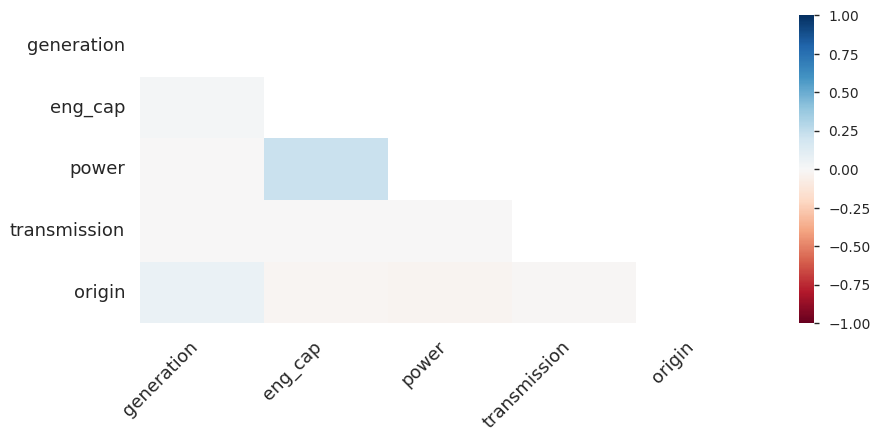

In [14]:
profile = ProfileReport(dataset, title='Car data analysis before processing')
profile.to_file('car_data_analysis_before_processing.html')

Before further data analysis, let's delete duplicated rows at the beginning:

In [15]:
dataset.drop_duplicates(inplace=True)

As we know from the reality, car model is unique for a certain brand, and also car generation is specific for a certain model, which means that we can drop the brand and model columns, because they are unambiguosly defined by the car generation.

In [16]:
dataset.drop(columns=['brand', 'model'], axis=1, inplace=True)

In [17]:
dataset['generation'].unique()

array(['VII (2012-2020)', 'VIII (2020-)', 'E90/E91/E92/E93 (2005-2012)',
       'D (2006-2014)', 'V (2003-2009)', 'F30/F31 (2012-2020)',
       'VI (2008-2013)', 'G20/G21 (2019-)', 'C (2000-2006)', 'F (2019-)',
       'IV (1997-2006)', 'E (2014-2019)', nan, 'E46 (1998-2007)',
       'I (1974-1983)', 'E30 (1982-1994)', 'III (1991-1998)',
       'B (1993-2000)', 'E36 (1990-1999)', 'E21 (1975-1982)',
       'II (1983-1992)', 'A (1982-1993)'], dtype=object)

*Now, let's take a look at the next columns and their correlation to the price:*

In [18]:
def correlation_and_distribution_visualisation(df, x_column, bins_nb=None, sort=False):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    order = None
    if sort:
        sorted_df = df.groupby(x_column)['price'].mean().sort_values().reset_index()
        order = sorted_df[x_column]

    axs[0] = sns.countplot(x=x_column, data=df, ax=axs[0], order=order)
    if bins_nb:
        axs[0].xaxis.set_major_locator(MaxNLocator(nbins=bins_nb))  # Adjust the number of bins here
    plt.setp(axs[0].xaxis.get_majorticklabels(), rotation='vertical')

    axs[1] = sns.barplot(x=x_column, y='price', data=df, ax=axs[1], order=order)
    if bins_nb:
        axs[1].xaxis.set_major_locator(MaxNLocator(nbins=bins_nb))  # Adjust the number of bins here
    plt.setp(axs[1].xaxis.get_majorticklabels(), rotation='vertical')
    
    plt.tight_layout()
    plt.show()

min_mileage = dataset['mileage'].min()
max_mileage = dataset['mileage'].max()

# Create bins that only include values from the column range
def create_bins(df, col, nb):
    min_ = df[col].min()
    max_ = df[col].max()
    return pd.cut(df[col], bins=np.linspace(min_, max_, nb))


Also, let's prepare function for filtering outliers:

In [19]:
def outlier_df(df, col, threshold=3):
    df = df[df[col].notna()]
    z = np.abs(stats.zscore(df[col]))
    outlier_indices = np.where(z > threshold)[0]
    return df.iloc[outlier_indices]

**generation**

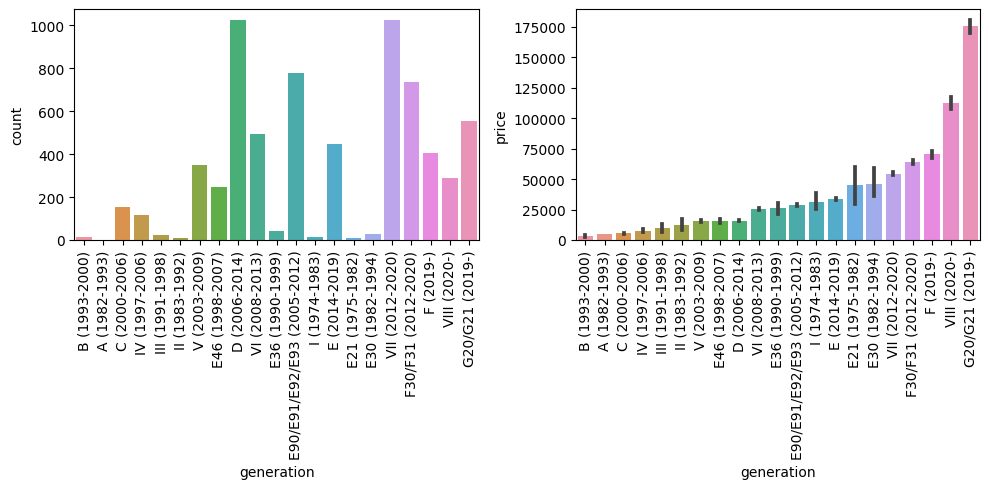

In [20]:
correlation_and_distribution_visualisation(dataset, 'generation', sort=True)

The correlation between the generation and the price is clearly visible here. Also, the assumption is that our model predicts the price of a certain car. If we deleted this feature we would loose the possibility to check the price of a chosen car - for these two reason, this column definitely has to stay in dataset.

**eng_cap**

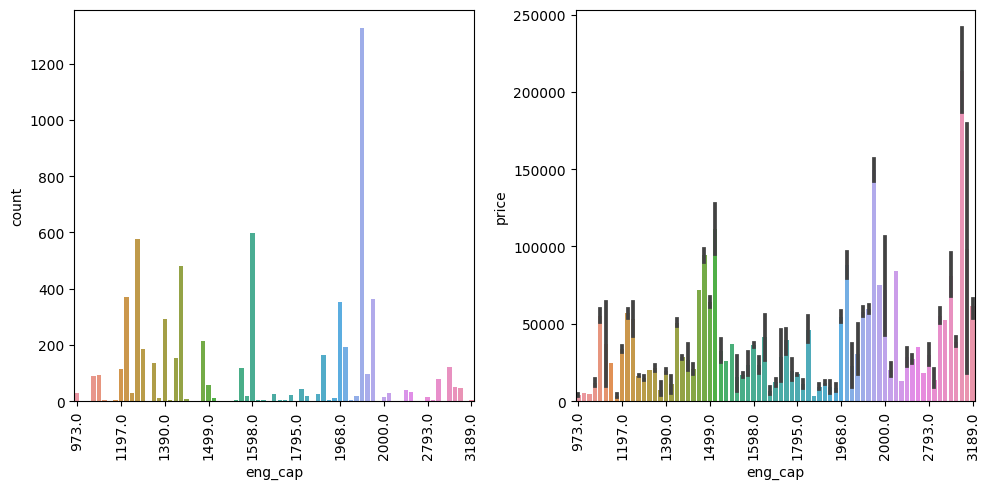

In [21]:
correlation_and_distribution_visualisation(dataset, 'eng_cap', 10)

As we can see, we don't deal with strong correlation between these two values. This is why we will not consider engine capacity as important - it is probably going to be dropped. Probably because we will first check how it influence the predictions of the model - it is highly possible that there are just certain, very popular types of engines (e.g. 2.0) and leaving it can improve the metrics.

After checking the end metrics with and without eng_cap - results were slightly better without dropping it, so that's what we are going to do.

In [22]:
outliers_eng_cap = outlier_df(dataset, 'eng_cap')
outliers_eng_cap

,generation,eng_cap,prod_year,power,fuel_type,car_body,mileage,color,condition,transmission,origin,price
1061,V (2003-2009),3189.0,2008,250.0,Benzyna,Kompakt,233700,Szary,Używane,Automatyczna,Stany Zjednoczone,64500.0
2130,V (2003-2009),3189.0,2006,250.0,Benzyna,Kompakt,197700,Srebrny,Używane,Automatyczna,Dania,53900.0
1347,V (2003-2009),3189.0,2006,250.0,Benzyna,Kompakt,161000,Granatowy,Używane,Manualna,Szwecja,65800.0


Let's delete outlier rows

In [23]:
dataset.drop(outliers_eng_cap.index, inplace=True)

**prod_year**

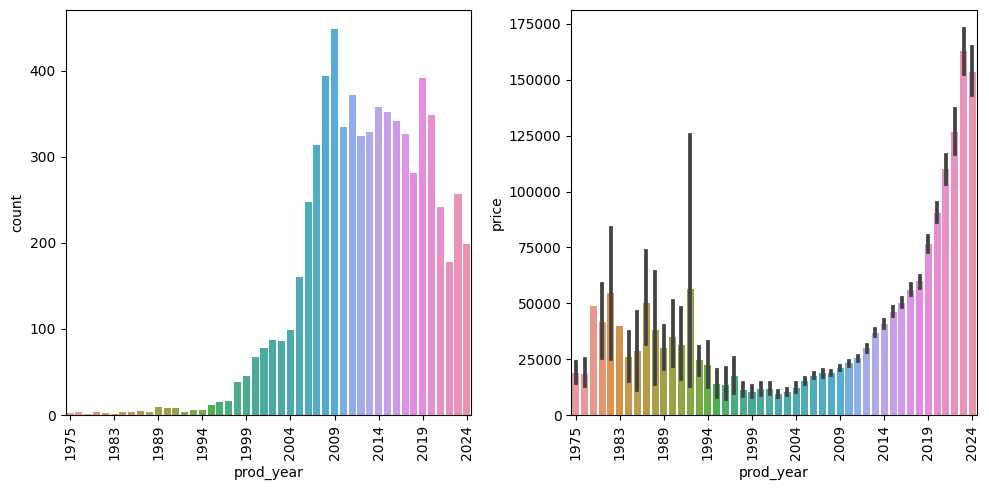

In [24]:
correlation_and_distribution_visualisation(dataset, 'prod_year', 10)

We can clearly see strong correlation here. The plot has a shape simillar to parabola. The cars from the left side of the plot are considered *classic cars* and their price is  statisticly higher than a little newer ones. But the newer the car gets, the price starts to raise and is the highest for the latest models. 

We have small amount of samples for old cars, let's see if they can be classified as outliers.

In [25]:
outliers_prod_year = outlier_df(dataset, 'prod_year')
print('Outliers of prod_year:', len(outliers_prod_year))
outliers_prod_year.head()

Outliers of prod_year: 58


,generation,eng_cap,prod_year,power,fuel_type,car_body,mileage,color,condition,transmission,origin,price
561,I (1974-1983),1085.0,1981,50.0,Benzyna,Kompakt,306000,Czerwony,Używane,Manualna,NaN,24900.0
237,E30 (1982-1994),1585.0,1989,99.0,Benzyna,Coupe,204000,Szary,Używane,Manualna,NaN,36999.0
1034,E30 (1982-1994),2793.0,1989,193.0,Benzyna,Coupe,200000,Pomarańczowy,Używane,Manualna,NaN,59900.0
2168,I (1974-1983),1457.0,1977,70.0,Benzyna,Auta małe,183855,Czerwony,Używane,Manualna,NaN,17700.0
1609,E30 (1982-1994),1596.0,1990,100.0,Benzyna+LPG,Sedan,384000,Czerwony,Używane,Manualna,NaN,33600.0


Because of high deviation of this samples from the rest, even though they can be good data - it will be better for our future model to remove these from dataset.

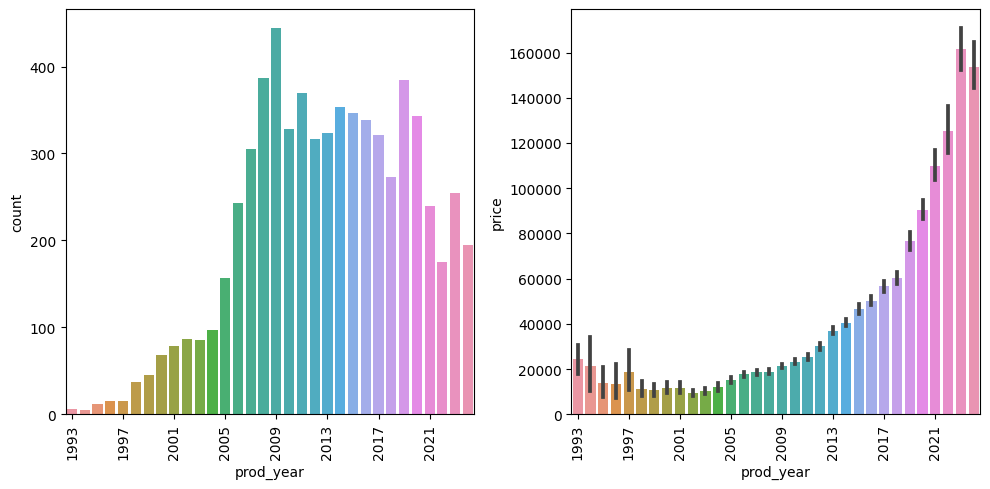

In [26]:
dataset.drop(outliers_prod_year.index, inplace=True)

correlation_and_distribution_visualisation(dataset, 'prod_year', 10)

**power**

c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


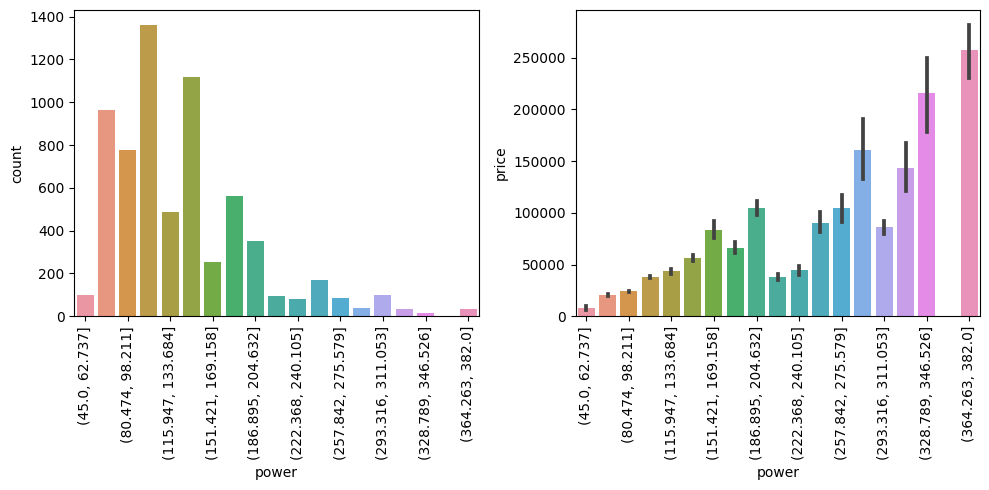

In [27]:
correlation_and_distribution_visualisation(dataset, 
                                           create_bins(df=dataset, col='power', nb=20), 
                                           10)

The correlation may not be very smooth, but it can be seen that the price goes up along with the power.

Outliers:

In [28]:
outliers_power = outlier_df(dataset, 'power')
outliers_power.head()

,generation,eng_cap,prod_year,power,fuel_type,car_body,mileage,color,condition,transmission,origin,price
1550,VII (2012-2020),1984.0,2017,310.0,Benzyna,Kompakt,77000,Biały,Używane,Automatyczna,NaN,114000.0
966,G20/G21 (2019-),2998.0,2023,374.0,Benzyna,Sedan,4100,Czerwony,Używane,Automatyczna,Polska,349900.0
1800,G20/G21 (2019-),2998.0,2024,374.0,Benzyna,Sedan,1,Czarny,Nowe,Automatyczna,Polska,295995.0
2260,VIII (2020-),1984.0,2024,320.0,Benzyna,Kompakt,10,Czarny,Nowe,Automatyczna,Polska,267360.0
2043,F30/F31 (2012-2020),2993.0,2014,313.0,Diesel,Kombi,230000,Biały,Używane,Automatyczna,Niemcy,59900.0


c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


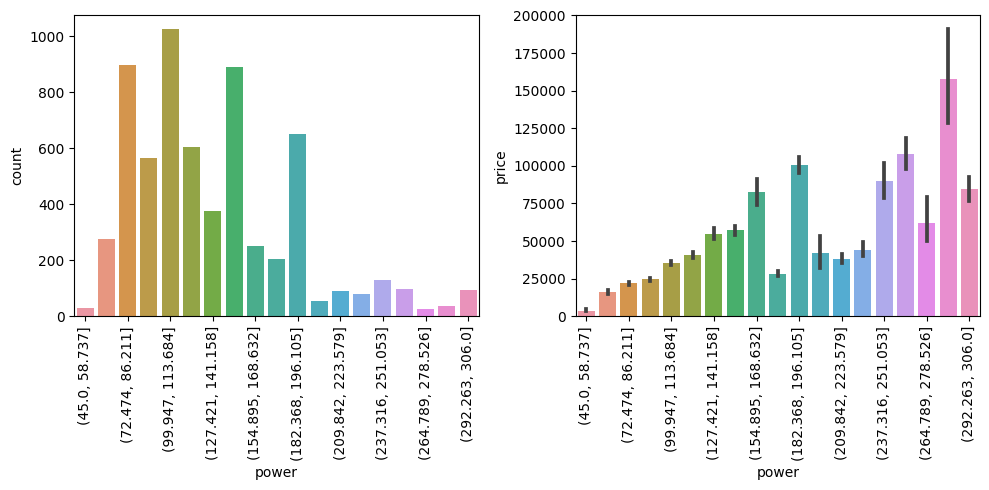

In [29]:
dataset.drop(outliers_power.index, inplace=True)
correlation_and_distribution_visualisation(dataset, 
                                           create_bins(df=dataset, col='power', nb=20), 
                                           10)

**fuel_type**

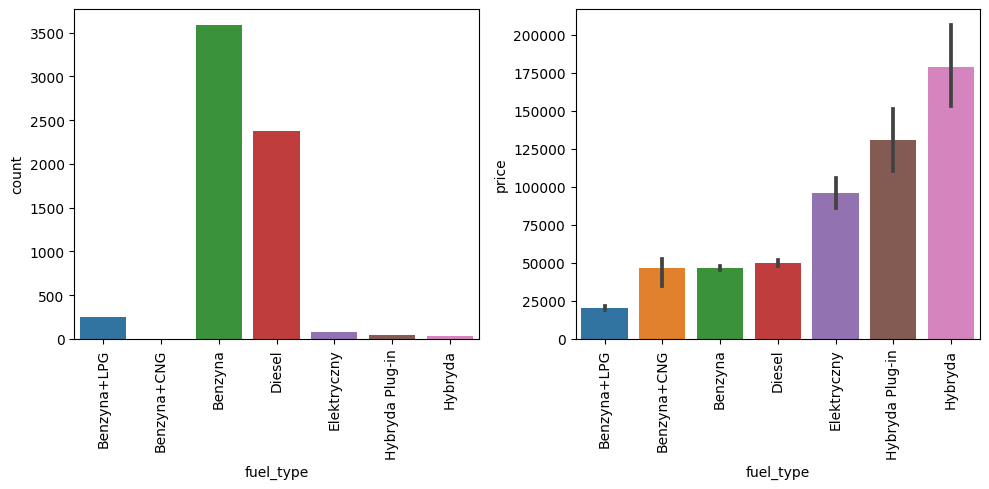

In [30]:
correlation_and_distribution_visualisation(dataset, 'fuel_type', sort=True)

Only two of all types of fuel can be found in most of the samples, which means it probably won't influence our future model well, even though there is a big difference in price between different fuels. It has to be dropped because of this lack of other fuels samples.

In [31]:
dataset.drop(columns='fuel_type', axis=1, inplace=True)

**car_body**

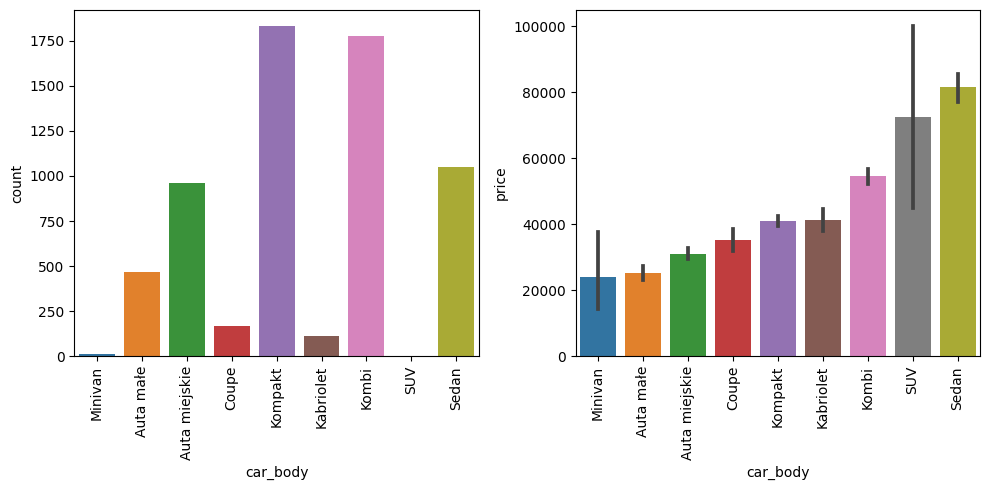

In [32]:
correlation_and_distribution_visualisation(dataset, 'car_body', sort=True)

The difference in price between different types of car body can be seen but also the data is not distributed evenly and there is a lot of missing values, almost 40%.

In [33]:
def count_unique_from_column(df, col):
    col_count_df = df.groupby([col]).count()['price']
    all_cars = dataset[col].count()
    percentage = col_count_df / all_cars*100
    result_df = pd.concat([col_count_df, percentage], axis=1, keys=['count', '% of all']) 
    result_df = result_df.sort_values(by='% of all', ascending=False)  # Sort by percentage
    return result_df

count_unique_from_column(dataset, 'car_body')


,count,% of all
car_body,,
Kompakt,1829,28.681198
Kombi,1777,27.865768
Sedan,1050,16.465423
Auta miejskie,961,15.069782
Auta małe,465,7.291830
Coupe,167,2.618786
Kabriolet,115,1.803356
Minivan,11,0.172495
SUV,2,0.031363


The distribution of the car body is far from even (there are only 12 Minivans and 2 SUVs), so it would be hard to actually use this column for our model. We will drop it.

In [34]:
dataset.drop(columns='car_body', inplace=True)

**Mileage**

c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


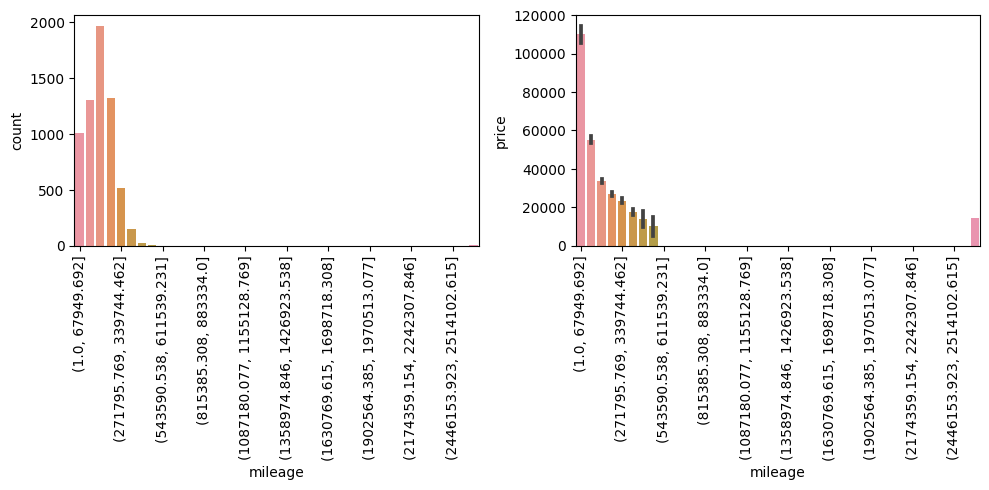

In [35]:
correlation_and_distribution_visualisation(dataset, 
                                           create_bins(df=dataset, col='mileage', nb=40),
                                           10)

As we can see, the data is far from being distributed normally, it looks like there might be some outliers that widen mileage range.

In [36]:
outliers = outlier_df(dataset, 'mileage')
outliers

,generation,eng_cap,prod_year,power,mileage,color,condition,transmission,origin,price
2428,E46 (1998-2007),1951.0,2002,115.0,470000,Czarny,Używane,Manualna,Niemcy,6900.0
999,V (2003-2009),1896.0,2008,105.0,520000,Szary,Używane,Manualna,Niemcy,5999.0
1591,E90/E91/E92/E93 (2005-2012),1995.0,2006,163.0,477000,Inny kolor,Używane,Manualna,Francja,16900.0
1410,E46 (1998-2007),1995.0,2004,115.0,450000,Czarny,Używane,Manualna,Niemcy,6900.0
171,E36 (1990-1999),1796.0,1999,115.0,2650000,Czarny,Używane,Manualna,NaN,14500.0
2054,D (2006-2014),1248.0,2010,75.0,489500,Srebrny,Używane,Manualna,Francja,9900.0
1794,VI (2008-2013),1598.0,2013,105.0,485000,Czarny,Używane,Manualna,Niemcy,16200.0
64,IV (1997-2006),1896.0,1998,68.0,493000,Srebrny,Używane,Manualna,NaN,1999.0
1082,IV (1997-2006),1896.0,2000,115.0,467400,Srebrny,Używane,Manualna,NaN,3499.0


Indeed there are 9 cars whose mileage is more than 3 times standard deviation. It is highly possible that these are not mistaken data and it is real mileage of this cars but for the model sake, it would be much better if we drop these rows from our dataset

c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


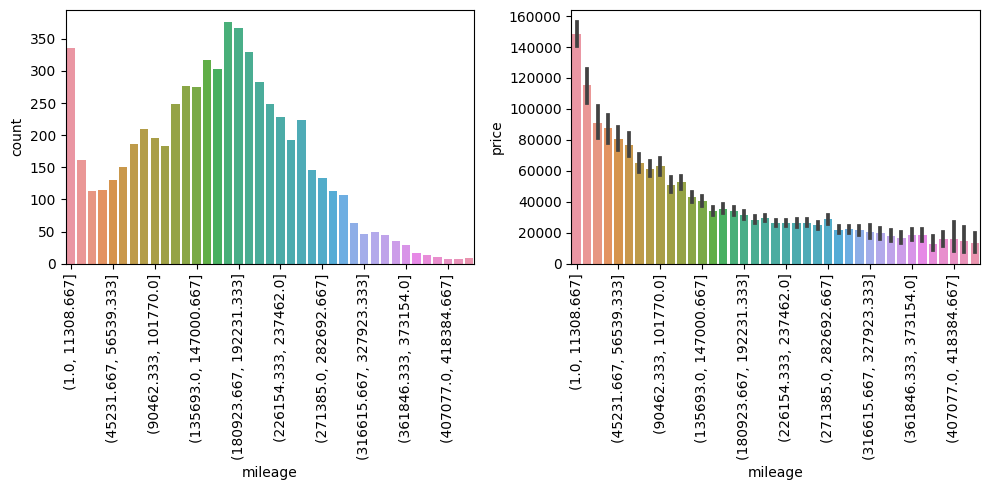

In [37]:
dataset.drop(outliers.index, inplace=True)

correlation_and_distribution_visualisation(dataset, 
                                           create_bins(df=dataset, col='mileage', nb=40),
                                           10)

As we can see now, our mileage is distributed similarly to the normal distribution. Also, we have very clear correlation between mileage and the price - as it could be predicted - the more a car has been driven, the more its price drops.

**color**

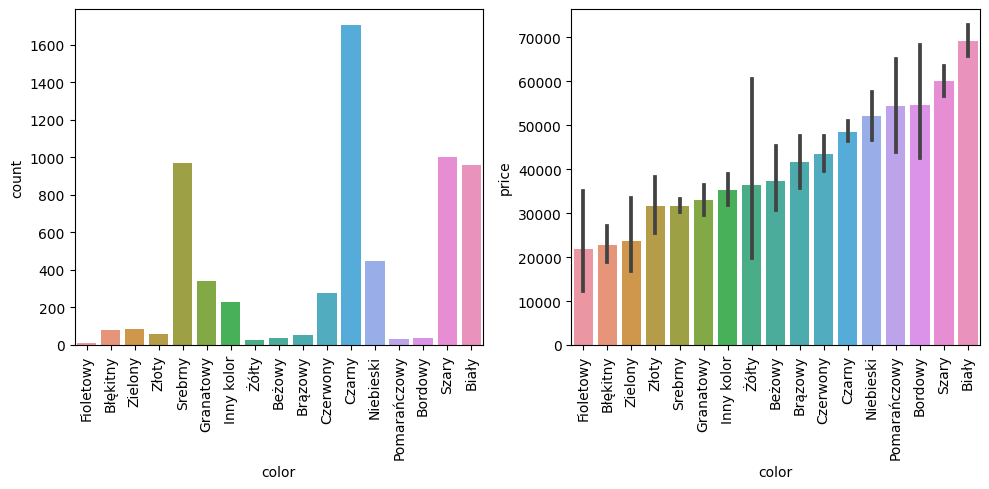

In [38]:
correlation_and_distribution_visualisation(dataset, 'color', sort=True)

In [39]:
count_unique_from_column(dataset, 'color')

,count,% of all
color,,
Czarny,1706,26.853455
Szary,1002,15.772076
Srebrny,968,15.236896
Biały,960,15.110971
Niebieski,448,7.051787
Granatowy,339,5.336062
Czerwony,279,4.391626
Inny kolor,231,3.636077
Zielony,86,1.353691


There are many different colors and only 4 of them makes up the majority, it would be hard to use such data, so we will drop the column

In [40]:
dataset.drop('color', axis=1, inplace=True)

**condition**

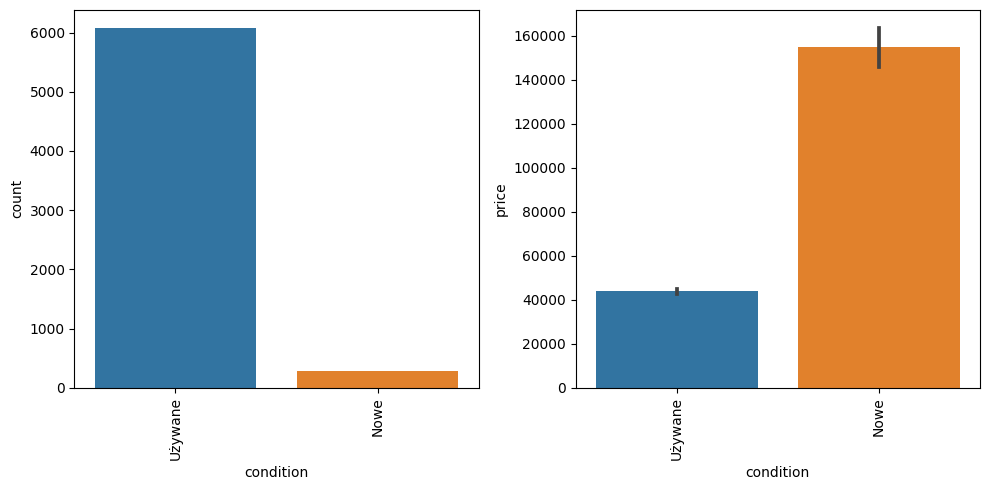

In [41]:
correlation_and_distribution_visualisation(dataset, 'condition', sort=True)

In [42]:
count_unique_from_column(dataset, 'condition')

,count,% of all
condition,,
Używane,6078,95.671336
Nowe,275,4.328664


There is a significant advantage in samples number on the 'used' side, but we cannot simply drop the whole column, because on the other hand new cars are much more expensive than used ones, which can be seen on the plot above. Because of this strong correlation the column will stay.

**transmission**

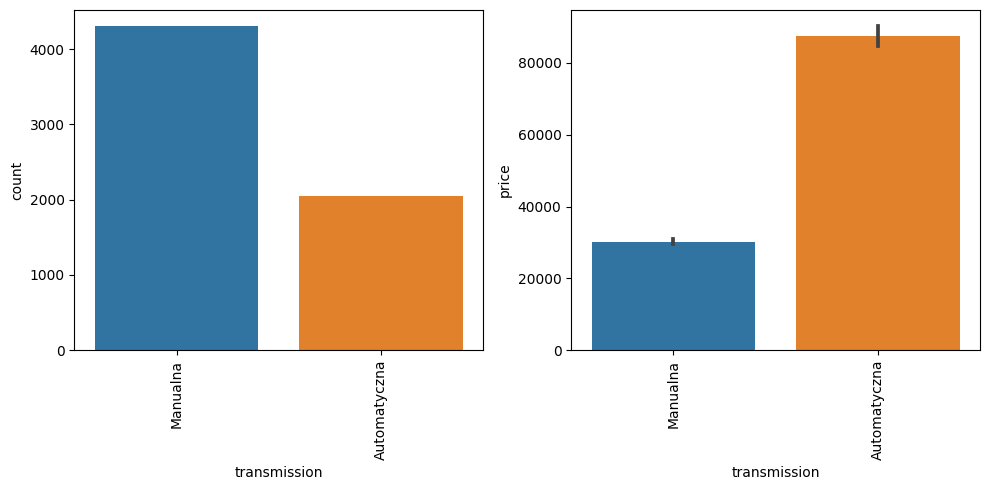

In [43]:
correlation_and_distribution_visualisation(dataset, 'transmission', sort=True)

In [44]:
count_unique_from_column(dataset, 'transmission')

,count,% of all
transmission,,
Manualna,4305,67.784601
Automatyczna,2046,32.215399


Here, we will leave the column as it is. The gap in number of automatic and manual transmission is not that huge, while the price difference between these two types is noticible.

**origin**

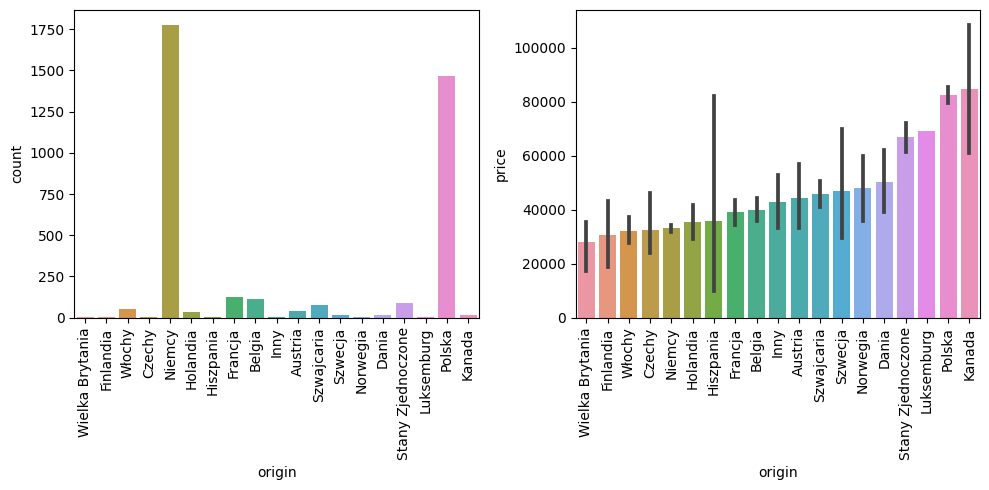

In [45]:
correlation_and_distribution_visualisation(dataset, 'origin', sort=True)

In [46]:
count_unique_from_column(dataset, 'origin')

,count,% of all
origin,,
Niemcy,1778,46.181818
Polska,1466,38.077922
Francja,126,3.272727
Belgia,115,2.987013
Stany Zjednoczone,90,2.337662
Szwajcaria,76,1.974026
Włochy,53,1.376623
Austria,40,1.038961
Holandia,33,0.857143


We don't have enough data about the origin for other countries than Poland and Germany, that is why we are going to drop this column

In [47]:
dataset.drop('origin', axis=1, inplace=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Używane'')
  warnings.warn(
c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
c:\Users\mmaks\miniconda3\envs\sem4\Lib\site-packages\ydata_profiling\model\missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calculat

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

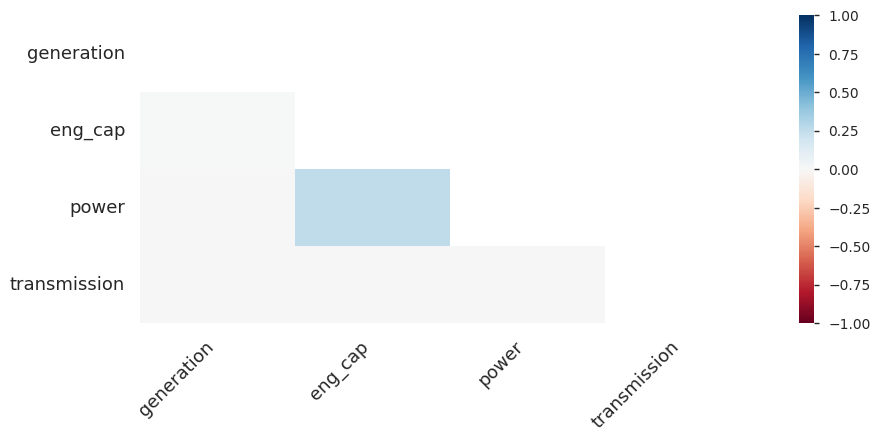

In [48]:
profile = ProfileReport(dataset, title='Car data analysis - after processing')
profile.to_file('car_data_analysis_after_processing.html')

As the missing cells makes only about 0.2% of the whole dataset, I decided to fill it all at once at the end. I will use following strategy:

for categorical values I will compute probability of occurance for every category and using it I will choose the category for every missing cell

for numeric values I will compute mean and replace empty cells with it 

In [49]:
categorical = ['generation', 'transmission', 'condition']
numeric = ['eng_cap', 'prod_year', 'power', 'mileage', 'price']

def fill_na_categorical(df, col):
    na_values = df[col].isna()
    if na_values.any():
        df_dict = count_unique_from_column(df, col).to_dict()['% of all']
        new_values = np.cumsum(list(df_dict.values()))
        for i, key in enumerate(df_dict.keys()):
            df_dict[key] = new_values[i]
        na_indices = np.where(na_values == True)[0]
        replacing_values = []
        for i in range(len(na_indices)):
            r = np.random.random()*100
            for key, val in df_dict.items():
                if r < val:
                    replacing_values.append(key)
                    break
        df.loc[na_values, col] = replacing_values
    return df

def fill_na_numeric(df, col):
    mean = df[col].mean()
    return df.fillna(mean)

for cat_col in categorical:
    dataset = fill_na_categorical(dataset, cat_col)

for num_col in numeric:
    dataset = fill_na_numeric(dataset, num_col)

print('Checking if there is actually no empty values in the whole dataset:')
print(dataset.columns[dataset.isna().any()].tolist())

Checking if there is actually no empty values in the whole dataset:
[]


We got rid of empty cells. Now, even though we deleted duplicated rows at the beginning, we should do it once again because after data reduction and filling (column dropping, NaN values filling) new duplicates could be created.

In [50]:
dataset.drop_duplicates(inplace=True)

**Correlation matrix**

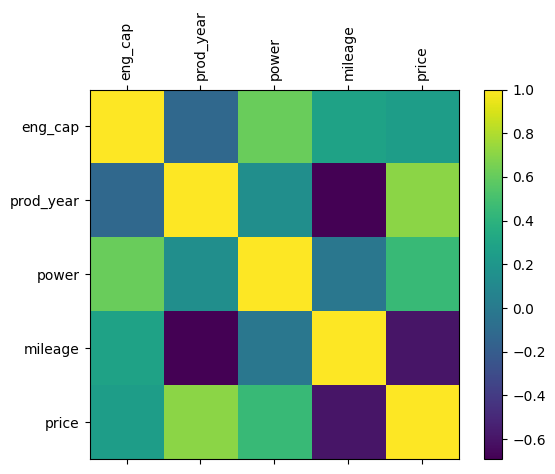

In [51]:
numeric_df = dataset[numeric]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(numeric_df.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = numeric_df.columns
xaxis = np.arange(len(alpha))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(alpha, rotation=90)
ax.set_yticklabels(alpha)

plt.show()

Now, when we almost fully prepared our data for the models (apart from encoding categorical features and normalization which come as the next actions), we can look how our features correlate with the price. For the sake of interpretation - I left only numeric values on the matrix (deleted categorical features).

As can be seen, engine capacity and power are slightly correlated with the price but the production year have the biggest correlation coeffitient (about 0.8). But as we can see the rest - that is mileage have very high absolute value of the coefficient, which means that the bigger the mileage gets, smaller the price gets, which actually make a lot of sense - it is quite an objective statement.

**Categorical Features**

Now let's head to one of the last parts of data preparation - which is transforming categorical columns, to the numeric ones. Because of many different categories e.g. in generation or in body_type, instead of one-hot encoding we are going to use label encoding.

In [52]:
def create_categorical_feature(df, col):
    label_encoder = preprocessing.LabelEncoder()
    new_df = df.copy()
    new_df[col] = label_encoder.fit_transform(df[col])
    return new_df

In [53]:
for col in categorical:
    dataset = create_categorical_feature(dataset, col)
dataset.head()

,generation,eng_cap,prod_year,power,mileage,condition,transmission,price
1221,17,1968.0,2022,150.0,32000,1,0,95000.0
1941,17,1968.0,2020,150.0,76020,1,0,86900.0
573,7,2996.0,2005,258.0,288858,1,1,32500.0
1511,14,1390.0,2007,122.0,180000,1,1,13400.0
1702,2,1229.0,2008,80.0,187000,1,1,14000.0


Now, we have to divide our data into X and y, where y is the price and then split our dataset in two parts: training dataset and testing dataset

In [54]:
X_columns = list(dataset.columns)
X_columns.remove('price')
X, y = dataset[X_columns], dataset['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED) # test_size=0.25

**Feature Scaling**

the last step in data preparation for our model will be scaling every numeric category (normalization)

In [55]:
scaler = StandardScaler()
def scale_features(df): 
    return scaler.fit_transform(df.astype(float))

X_train = scale_features(X_train)
X_test = scale_features(X_test)

Now, the data should be prepared quite well as the model input. Now we are heading to the part where we experiment to choose the model that predicts our data the best.

## MODELS

We are going to use **Grid Search** in order to find the best hyperparameters for our model

In [56]:
def find_best_parameters(model, parameters, X, y, scoring='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1):
    grid_object = GridSearchCV(model, parameters, scoring=scoring, cv=cv, verbose=verbose, n_jobs=n_jobs)
    grid_object = grid_object.fit(X, y)
    return grid_object.best_estimator_

As we are dealing with multidimensional not linear regression, we have to choose a model appropriate for such task.

*We will try using*:

**Random Forest** - because of its capability to capture nonlinear correlations

**Decision Tree** - because of its capability of handling a lot of categorical features

**Gradient Boosting** - our dataset is not that big so we don't have to worry about computation time

**Random Forest**

In [57]:
random_forest = RandomForestRegressor()

parameters = {'n_estimators': [100, 200, 300],    # The number of trees in the forest
              'max_depth': [None, 5, 10],    # Maximum depth of the tree
              'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split
              'random_state': [SEED]    # Random seed for reproducibility
             }

random_forest = find_best_parameters(random_forest, parameters, X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


**Decision Tree**

In [58]:
dtree = DecisionTreeRegressor()

parameters = {  # Criterion for splitting
    'splitter': ['best', 'random'],              # Strategy for splitting
    'max_depth': [None, 10, 20, 30],             # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split
    'min_samples_leaf': [1, 2, 4],               # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2'],    # Number of features to consider for best split
    'random_state': [SEED]                         # Random seed for reproducibility
}

dtree = find_best_parameters(dtree, parameters, X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


**Gradient Boosting Regressor**

In [59]:
gbr = GradientBoostingRegressor()

parameters = {
    'loss': ['squared_error', 'huber', 'quantile'],     # Loss function to be optimized
    'max_depth': [3, 5],                         # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 5],                # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4],                  # Minimum number of samples required to be at a leaf node
    'random_state': [SEED]                            # Random seed for reproducibility
}

gbr = find_best_parameters(gbr, parameters, X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


## Presenting metrics and picking the best model

In [60]:
models = {
    'Random Forest': random_forest,
    'Decision Tree': dtree,
    'Gradient Boosting': gbr
}

def get_metrics(metrics_func, models, X_t, y_t):
    metrics = [[k, None] for k in models.keys()]
    for i, (name, mod) in enumerate(models.items()):
        y_pr = mod.predict(X_t)
        metrics[i][1] = metrics_func(y_t, y_pr)
    metrics.sort(key = lambda model: model[1])
    results = pd.DataFrame(data=metrics, columns=['Model', 'Score'])
    return results

For the sake of our models, we will use 2 basic and one custom metric. First two will be: mean absolute error and root mean squared error.

**MAE**

It will be the most basic metric, showing on average how big mistakes our model is making in price prediction per car.

In [61]:
get_metrics(mean_absolute_error, models, X_test, y_test)

,Model,Score
0,Random Forest,7603.170461
1,Gradient Boosting,7659.336081
2,Decision Tree,9878.312088


It basically means that: y_predicted =~ y_true +/- 7812 PLN (for Random Forest)

**RMSE**

It will also show the approx. mistake in price per car, but this metric is more sensitive in case of larger errors.

In [62]:
get_metrics(root_mean_squared_error, models, X_test, y_test)

,Model,Score
0,Random Forest,12982.602908
1,Gradient Boosting,13317.084722
2,Decision Tree,16654.511922


The custom metric will be computed basically using root mean squared error function, because it will represent the price uncertainty and also I found  any outliers produced by the model quite important - model which makes bigger but quite simillar mistakes should score higher than model which makes most of the mistakes lower but at the same time - some very high. Substracting the RMSE from average car price, and dividing the result by this average will get us value which will represent how big mistake, on average, the model is making while predicting the price. If the value of the metrics is negative - it means that model is making mistakes even bigger than average car price.

In [63]:
def prediction_function(y_t, y_pred):
    err = root_mean_squared_error(y_t, y_pred)
    y_t_mean = np.mean(y_t)
    return (y_t_mean-err)/y_t_mean

In [64]:
results = get_metrics(prediction_function, models, X_test, y_test)
display(results)

,Model,Score
0,Decision Tree,0.656412
1,Gradient Boosting,0.725264
2,Random Forest,0.732165


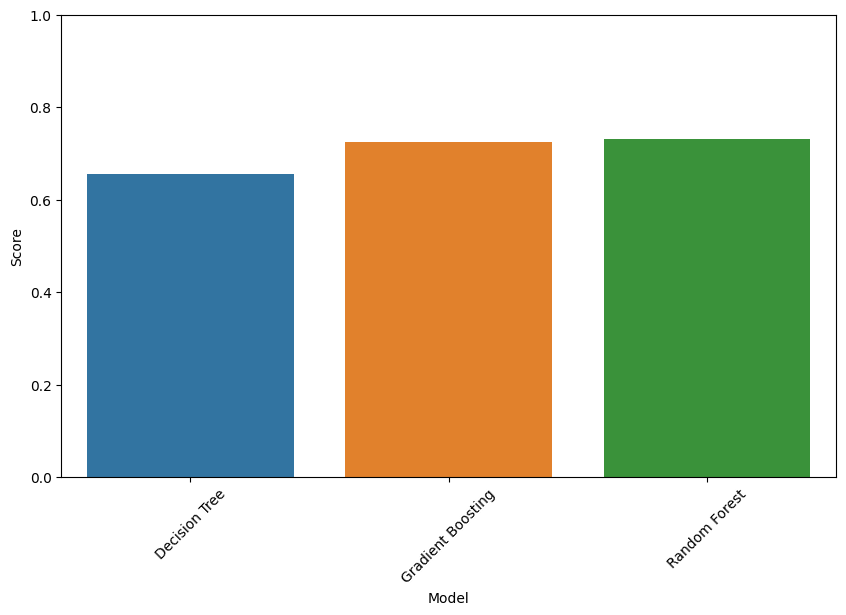

In [65]:
plt.figure(figsize=(10,6))
plot=sns.barplot(x='Model', y='Score', data=results)
plot.set(ylim=(0, 1))
plt.xticks(rotation=45)
plt.show()

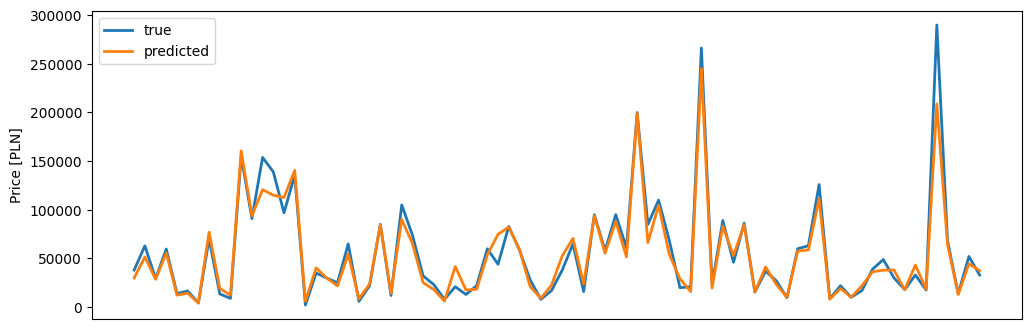

In [66]:
res = 20 # Resolution

Y_true = y_test[::res]
X = np.linspace(0, 1, len(Y_true))
Y_pred = random_forest.predict(X_test)[::res]

plt.figure(figsize=(12, 4))
plt.plot(X, Y_true, label='true', linewidth=2)
plt.plot(X, Y_pred, label='predicted', linewidth=2)

plt.ylabel('Price [PLN]')
plt.xticks([])  # Removes the x-axis tick labels
plt.gca().xaxis.set_tick_params(length=0)  # Hides the tick marks

plt.legend()
plt.show()

Here, we can see how the best model - Random Forest performed on test data. We took every 20'th price sample for test and for each of them we used model to create predicted substitute - and we compare them on the same plot.

# Conclusion

All of the models scored quite simillarly. The difference between them was less than 8%. Decision Tree scored the lowest. Gradient Boosting and Random Forest results were almost the same, but Random Forest score was approx. 1% higher and also the highest among them all with the score of 73,2%.